# I had trouble trying to get the time conditional model to work

This code is a heavy revamp of the code provided [by JM Tomczak](https://jmtomczak.github.io/blog/10/10_ddgms_lvm_p2.html)

In particular
- It appears that their is a bug in the loss of the provided code. Namely incorrectly calculating KL-div



There are a number of things to do
- Implement a non-constant beta
- Attempt the only learn the mean function (ie, don't learn backward variance and set it equal to beta)
- implement the swiss roll example
    - This will provide nice plots and proof of concept
- Show that the loss shown in the above page is equivalent to the one in "Deep Unsupervised Learning using Nonequilibrium Thermodynamics"
    - If it is not, how is it different

In [1]:
import os

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
class DiffusionModel(nn.Module):
    def __init__(self, beta : int, data_dim:int, T : int, model_dim : int):
        super(DiffusionModel, self).__init__()
        
        # This model reconstructs our input x from the last value of our latent variable
        self.decoder_net = nn.Sequential(nn.Linear(data_dim, model_dim*2), nn.LeakyReLU(),
                                    nn.Linear(model_dim*2, model_dim*2), nn.LeakyReLU(),
                                    nn.Linear(model_dim*2, model_dim*2), nn.LeakyReLU(),
                                    nn.Linear(model_dim*2, data_dim))
        
        # These models predict the mean and standard deviation of the backward process
        self.backward_models = nn.ModuleList([nn.Sequential(nn.Linear(data_dim, model_dim), nn.LeakyReLU(),
                        nn.Linear(model_dim, model_dim), nn.LeakyReLU(),
                        nn.Linear(model_dim, model_dim), nn.LeakyReLU(),
                        nn.Linear(model_dim, 2 * data_dim)) for _ in range(T-1)])


        # Data dimension
        self.data_dim = data_dim

        # How many time steps are we taking
        self.T = T
        
        self.register_buffer('beta', torch.tensor([beta], dtype = torch.float32))


    @staticmethod
    def reparameterization(mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def reparameterization_gaussian_diffusion(self, x, i):
        return torch.sqrt(1. - self.beta) * x + torch.sqrt(self.beta) * torch.randn_like(x)

    def forward(self, x, reduction='avg'):
        # =====
        # forward difussion
#         zs = [x]
        zs = [self.reparameterization_gaussian_diffusion(x, 0)]

        for i in range(1, self.T):
            zs.append(self.reparameterization_gaussian_diffusion(zs[-1], i))

        # =====
        # backward diffusion
        mus = []
        log_vars = []

        for i in range(len(self.backward_models) - 1, -1, -1):
            h = self.backward_models[i](zs[i+1])
            mu_i, log_var_i = torch.chunk(h, 2, dim=1)
            mus.append(mu_i)
            log_vars.append(log_var_i)

        mu_x = self.decoder_net(zs[0])

        
        
        return mu_x, mus, log_vars, zs        

    def sample(self, batch_size, device):
        z = torch.randn([batch_size, self.data_dim]).to(device) * self.beta
        for i in range(len(self.backward_models) - 1, -1, -1):
            h = self.backward_models[i](z)
            mu_i, log_var_i = torch.chunk(h, 2, dim=1)
            z = self.reparameterization(torch.tanh(mu_i), log_var_i)

        mu_x = self.decoder_net(z)

        return mu_x

    def sample_diffusion(self, x):
        zs = [self.reparameterization_gaussian_diffusion(x, 0)]

        for i in range(1, self.T):
            zs.append(self.reparameterization_gaussian_diffusion(zs[-1], i))

        return zs[-1]
    
    
## Like MNIST but simpler
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1350].astype(np.float32)
        else:
            self.data = digits.data[1000:].astype(np.float32)

        self.targets = digits.target
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        
        if self.transforms:
            sample = self.transforms(sample)
        return sample, target    

def digits_loader(batch_size:int):
    transform = transforms.Lambda(lambda x: 2. * (x / 17.) - 1.)
    train_data = Digits(mode='train', transforms=transform)
    test_data = Digits(mode='test', transforms=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory= True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, test_loader    
            
def mnist_loader(batch_size: int):
    train_set = datasets.MNIST('data', train=True,
                               transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,)),
                                    transforms.Lambda(lambda x: torch.flatten(x))                                   
                               ]), download=True)
    val_set = datasets.MNIST('data', train=False,
                             transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,)),
                                    transforms.Lambda(lambda x: torch.flatten(x))
                             ]), download=True)

    train_loader = DataLoader(train_set, batch_size=batch_size, pin_memory=True)

    test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory= True)

    return train_loader, test_loader    

In [3]:
#### Helper functions
PI = torch.from_numpy(np.asarray(np.pi))

def log_normal_diag(x, mu, log_var):
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.

    return log_p

def log_standard_normal(x, reduction=None, dim=None):
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * x**2.
    
    return log_p

#### Loss function
def calculate_ELBO(x, mu_x, mus, log_vars, zs, reduction = 'avg'):
    reconstruction = F.mse_loss(x,mu_x)

    # KL
    log_q = log_normal_diag(zs[-1], torch.sqrt(1. - model.beta) * zs[-1], torch.log(model.beta))
    q = torch.exp(log_q)
    loq_std_normal =  log_standard_normal(zs[-1])
    KL = (q * (log_q - loq_std_normal)).sum(-1)

    for i in range(len(mus)):
        log_q = log_normal_diag(zs[i], torch.sqrt(1. - model.beta) * zs[i], torch.log(model.beta))
        q = torch.exp(log_q)
        log_p = log_normal_diag(zs[i], mus[i], log_vars[i])
        KL_i = (q * (log_q - log_p)).sum(-1)

        KL += KL_i

    # Final ELBO
    if reduction == 'sum':
        loss = (reconstruction + KL).sum()
    else:
        loss = (reconstruction + KL).mean()

    return loss

In [4]:
def train_epoch(epoch, train_loader):    
    model.train()
    for data, _ in train_loader:    
        data = data.to(device)
        optimizer.zero_grad()
        mu_x, mus, log_vars, latents = model(data)
        
        loss = calculate_ELBO(data, mu_x,mus,log_vars,latents)
        
        loss.backward()
        optimizer.step()        
        
def test_epoch(epoch, test_loader, output_epochs = 10):        
    model.eval()
    loss = 0
    N = 0
    for data, _ in test_loader:
        data = data.to(device)
        mu_x, mus, log_vars, latents = model(data)
        
        loss_t = calculate_ELBO(data, mu_x,mus,log_vars,latents, reduction='sum')

        loss += loss_t.item()
        N += data.shape[0]

    loss = loss / N
    
    if epoch % output_epochs == 0:
        print(f'Epoch: {epoch}, NLL = {loss}')
  
    return loss

In [14]:
### Define datasets

dataset = 'digits'
# dataset = 'mnist'
batch_size = 64

if dataset == 'digits':
    train_loader, test_loader = digits_loader(batch_size = batch_size)
    data_width = 8
    data_dim = data_width**2
    output_epochs = 10
elif dataset == 'mnist':     
    train_loader, test_loader = mnist_loader(batch_size = batch_size)
    data_width = 28
    data_dim = data_width**2
    output_epochs = 1
            

## Define hyperparameters
hidden_size = 256 # size of layers in model
lr = 1e-3 
T = 5 # Number diffusion steps
beta = 0.65 # Diffusion coefficient 
early_stop = 40
num_epochs = 80

### Define model and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DiffusionModel(beta = beta , data_dim = data_dim, T = T, model_dim = hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_loss = 1000
epochs_since_improvement = 0
for epoch in range(num_epochs):    
    train_epoch(epoch, train_loader)
    test_loss = test_epoch(epoch, test_loader, output_epochs = output_epochs)
    if test_loss < best_loss:
        best_model = deepcopy(model.state_dict())
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
        if epochs_since_improvement > early_stop:
            break
    
        

Epoch: 0, NLL = 801.0619880859375
Epoch: 1, NLL = 808.56453671875
Epoch: 2, NLL = 778.929105859375
Epoch: 3, NLL = 765.1851318359375
Epoch: 4, NLL = 811.04311953125
Epoch: 5, NLL = 758.7857748046875
Epoch: 6, NLL = 756.0511046875
Epoch: 7, NLL = 798.1925791992187
Epoch: 8, NLL = 748.2592017578125
Epoch: 9, NLL = 751.6910935546875
Epoch: 10, NLL = 741.8530873046875
Epoch: 11, NLL = 811.5537741210937
Epoch: 12, NLL = 746.6348821289063
Epoch: 13, NLL = 750.0553068359375
Epoch: 14, NLL = 747.008893359375
Epoch: 15, NLL = 788.5396337890625
Epoch: 16, NLL = 810.6643267578125
Epoch: 17, NLL = 738.8745068359375
Epoch: 18, NLL = 749.0990177734375
Epoch: 19, NLL = 732.7618497070313
Epoch: 20, NLL = 817.565540234375
Epoch: 21, NLL = 744.5454220703125
Epoch: 22, NLL = 758.284313671875
Epoch: 23, NLL = 736.47230859375
Epoch: 24, NLL = 729.1244671875
Epoch: 25, NLL = 825.3300177734375
Epoch: 26, NLL = 739.2842083984375
Epoch: 27, NLL = 738.036493359375
Epoch: 28, NLL = 748.683581640625
Epoch: 29, NL

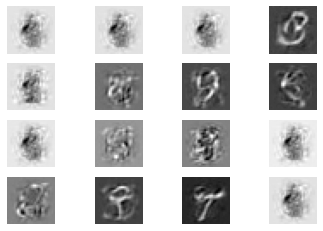

In [15]:
model.load_state_dict(best_model)
model.eval()

num_x = 4
num_y = 4
x = model.sample(batch_size=num_x * num_y, device = device)
x = x.cpu().detach().numpy()

fig, ax = plt.subplots(num_x, num_y)
for i, ax in enumerate(ax.flatten()):
    plottable_image = np.reshape(x[i], (data_width, data_width))
    ax.imshow(plottable_image, cmap='gray')
    ax.axis('off')

plt.show()
    # plt.savefig(name + '_generated_images' + extra_name + '.png', bbox_inches='tight')
plt.close()